In [15]:
# %%
# Unet.ipynb
# For image segmentation, Image : /home/VirtualFlaw/Dataset_Unet/VF/ACC, Label : /home/VirtualFlaw/Dataset_Unet/VF/REJ
# image size : 512, batch size : 64, learning rate : 0.0001, loss function : Dice Loss
# Use Tensorflow
#
# Path: VirtualFlaw/Dataset_Unet/Unet.ipynb

# %%
import tensorflow as tf
import os
import random
import numpy as np
 
from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [11]:
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 3

TRAIN_PATH = '/home/VirtualFlaw/Dataset_Unet/VF/REJ/'
TRAIN_MASK_PATH = '/home/VirtualFlaw/Dataset_Unet/VF/DIFF/'
TEST_PATH = '/home/VirtualFlaw/Dataset_Unet/Test/Image/'

train_ids = os.listdir(TRAIN_PATH)
test_ids = os.listdir(TEST_PATH)

print(len(train_ids), len(test_ids))


X = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
y = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = cv2.imread(path)
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X[n] = img
    mask_path = TRAIN_MASK_PATH + id_
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    mask = np.expand_dims(mask, axis=-1)
    y[n] = mask
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



19955 58


100%|██████████| 19955/19955 [05:51<00:00, 56.69it/s]


In [12]:
test_images = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = cv2.imread(path)
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    test_images[n] = img

100%|██████████| 58/58 [00:01<00:00, 41.93it/s]


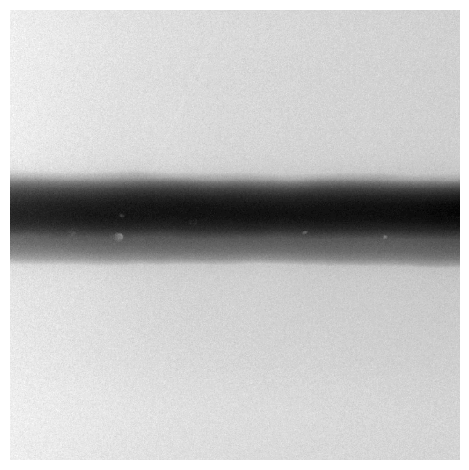

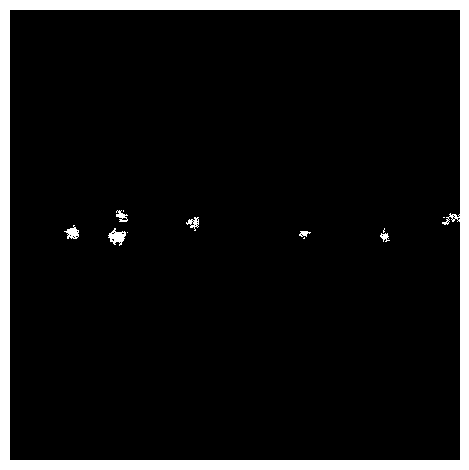

In [17]:
image_x = random.randint(0, len(X_train))
plt.axis("off")
imshow(X_train[image_x])
plt.show()
plt.axis("off")
imshow(np.squeeze(y_train[image_x]))
plt.show()

In [20]:
mirrored_strategy = tf.distribute.MirroredStrategy()
with mirrored_strategy.scope():
    num_classes = 1
    inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    b1 = tf.keras.layers.BatchNormalization()(c1)
    r1 = tf.keras.layers.ReLU()(b1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(r1)
    
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    b2 = tf.keras.layers.BatchNormalization()(c2)
    r2 = tf.keras.layers.ReLU()(b2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(r2)
    
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    b3 = tf.keras.layers.BatchNormalization()(c3)
    r3 = tf.keras.layers.ReLU()(b3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(r3)
    
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    b4 = tf.keras.layers.BatchNormalization()(c4)
    r4 = tf.keras.layers.ReLU()(b4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(r4)
    
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    b5 = tf.keras.layers.BatchNormalization()(c5)
    r5 = tf.keras.layers.ReLU()(b5)
    c5 = tf.keras.layers.Dropout(0.3)(r5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path 
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.BatchNormalization()(u6)
    u6 = tf.keras.layers.ReLU()(u6)

    
    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(u6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.BatchNormalization()(u7)
    u7 = tf.keras.layers.ReLU()(u7)

    
    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(u7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.BatchNormalization()(u8)
    u8 = tf.keras.layers.ReLU()(u8)
    
    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(u8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    u9 = tf.keras.layers.BatchNormalization()(u9)
    u9 = tf.keras.layers.ReLU()(u9)

    
    outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(u9)
    
    checkpoint = ModelCheckpoint('/home/VirtualFlaw/Dataset_Unet/Model/unet.h5', monitor='val_loss', save_best_only=True, mode="auto")
    early_stop = EarlyStopping(monitor='val_loss', patience=8, mode='min')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, mode='min', min_lr=1e-6)
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task

In [24]:
tf.keras.utils.plot_model(model, "model.png")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [25]:
history = model.fit(X_train, y_train, validation_data=(X_test,y_test), batch_size=16, epochs=50, callbacks=[checkpoint, early_stop, reduce_lr])

Epoch 1/50
INFO:tensorflow:batch_all_reduce: 48 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 48 all-reduces with algorithm = nccl, num_packs = 1


2023-05-02 23:14:10.752206: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-05-02 23:14:14.306592: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8801
2023-05-02 23:14:15.493621: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8801
2023-05-02 23:14:16.650161: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8801
2023-05-02 23:14:17.391717: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-02 23:14:17.712142: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8801
2023-05-02 23:14:20.295004: I tensorflow/compiler/xla/service/service.cc:173] XL

872/873 [============================>.] - ETA: 0s - loss: 0.0477 - accuracy: 0.9929

2023-05-02 23:15:22.345359: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-02 23:15:22.345410: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-02 23:15:22.371267: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-02 23:15:22.371298: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU

873/873 [==============================] - 84s 68ms/step - loss: 0.0476 - accuracy: 0.9929 - val_loss: 0.0097 - val_accuracy: 0.9967 - lr: 0.0010
Epoch 2/50
873/873 [==============================] - 49s 56ms/step - loss: 0.0092 - accuracy: 0.9969 - val_loss: 0.0079 - val_accuracy: 0.9971 - lr: 0.0010
Epoch 3/50
873/873 [==============================] - 49s 56ms/step - loss: 0.0077 - accuracy: 0.9971 - val_loss: 0.0076 - val_accuracy: 0.9972 - lr: 0.0010
Epoch 4/50
873/873 [==============================] - 48s 56ms/step - loss: 0.0072 - accuracy: 0.9972 - val_loss: 0.0073 - val_accuracy: 0.9973 - lr: 0.0010
Epoch 5/50
873/873 [==============================] - 49s 56ms/step - loss: 0.0070 - accuracy: 0.9972 - val_loss: 0.0067 - val_accuracy: 0.9973 - lr: 0.0010
Epoch 6/50
873/873 [==============================] - 49s 56ms/step - loss: 0.0068 - accuracy: 0.9973 - val_loss: 0.0067 - val_accuracy: 0.9973 - lr: 0.0010
Epoch 7/50
873/873 [==============================] - 49s 56ms/step -

In [29]:
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

plt.figure()
plt.plot( loss, 'r', label='Training loss')
plt.plot( val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')

plt.legend()
plt.show()

KeyError: 'loss'

1/1 [==============================] - 0s 171ms/step


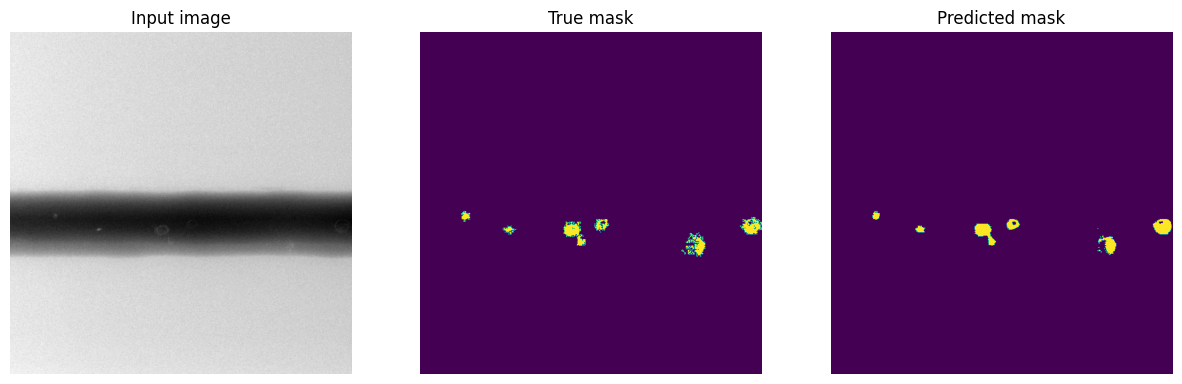

In [37]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input image', 'True mask', 'Predicted mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()
  
i = random.randint(0, len(X_test))
sample_image = X_test[i]
sample_mask = y_test[i]
prediction = model.predict(sample_image[tf.newaxis, ...])[0]
predicted_mask = (prediction > 0.5).astype(np.uint8)
display([sample_image, sample_mask,predicted_mask])

2023-05-02 23:54:45.716486: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at transpose_op.cc:142 : INVALID_ARGUMENT: transpose expects a vector of size 5. But input(1) is a vector of size 4
2023-05-02 23:54:45.716568: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at transpose_op.cc:142 : INVALID_ARGUMENT: transpose expects a vector of size 5. But input(1) is a vector of size 4
2023-05-02 23:54:45.716596: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at transpose_op.cc:142 : INVALID_ARGUMENT: transpose expects a vector of size 5. But input(1) is a vector of size 4


InvalidArgumentError: Graph execution error:

4 root error(s) found.
  (0) INVALID_ARGUMENT:  transpose expects a vector of size 5. But input(1) is a vector of size 4
	 [[{{node model_1/conv2d_11/ArithmeticOptimizer/ReorderCastLikeAndValuePreserving_uint8_Conv2D-0-TransposeNHWCToNCHW-LayoutOptimizer}}]]
	 [[model_1/conv2d_21/Sigmoid/_105]]
	 [[replica_2/model_1/conv2d_21/Sigmoid/_137]]
	 [[group_deps/_157]]
  (1) INVALID_ARGUMENT:  transpose expects a vector of size 5. But input(1) is a vector of size 4
	 [[{{node model_1/conv2d_11/ArithmeticOptimizer/ReorderCastLikeAndValuePreserving_uint8_Conv2D-0-TransposeNHWCToNCHW-LayoutOptimizer}}]]
	 [[model_1/conv2d_21/Sigmoid/_105]]
	 [[replica_2/model_1/conv2d_21/Sigmoid/_137]]
  (2) INVALID_ARGUMENT:  transpose expects a vector of size 5. But input(1) is a vector of size 4
	 [[{{node model_1/conv2d_11/ArithmeticOptimizer/ReorderCastLikeAndValuePreserving_uint8_Conv2D-0-TransposeNHWCToNCHW-LayoutOptimizer}}]]
	 [[model_1/conv2d_21/Sigmoid/_105]]
  (3) INVALID_ARGUMENT:  transpose expects a vector of size 5. But input(1) is a vector of size 4
	 [[{{node model_1/conv2d_11/ArithmeticOptimizer/ReorderCastLikeAndValuePreserving_uint8_Conv2D-0-TransposeNHWCToNCHW-LayoutOptimizer}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_predict_function_354267]